# **IE6400 Foundations Data Analytics Engineering**

#### Fall Semester 2025
#### Group Project by Rutvij Surti and Kush Patel
#### Project 2: Customer Segmentation using RFM Analysis


In [99]:
#importing the required libraries 

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [100]:
#loading the dataset 
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# Display the first few rows
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1. Data Overview



In [101]:
# Displaying the number of rows and columns

print("The number of rows in the Dataset", df.shape[0])
print("The number of columns in the Dataset", df.shape[1])

The number of rows in the Dataset 541909
The number of columns in the Dataset 8


In [102]:
#Summary of the dataset

df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [103]:
#concise summary of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [104]:
# Summary statistics for categorical variables

df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [105]:
# to identify and count the number of missing (null or NaN) values in each column

missing_data = df.isnull().sum()
missing_data


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [106]:
# to calculate the percentage of missing values in each column 

missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

In [107]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns

df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [108]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns

df = df.dropna(subset=['CustomerID', 'Description'])

In [109]:
#displaying the number of rows and columns 

df.shape

(406829, 8)

In [110]:
# Verifying the removal of missing values

df.isnull().sum().sum()

np.int64(0)

### Handling the Duplicate data 

In [111]:
# Finding duplicate rows (keeping all instances)

duplicate_rows = df[df.duplicated(keep=False)]


# Sorting the data by certain columns to see the duplicate rows next to each other

duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])


# Displaying the first 10 records

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [112]:
# Removing duplicate rows


df.drop_duplicates(inplace=True)

In [113]:
#displaying the number of rows and columns 

df.shape

(401604, 8)

In [114]:
# displaying the first few rows of the cleaned dataset 

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 2. Customer Analysis

In [115]:
# Q 1. Count the number of unique customers

unique_customers = df['CustomerID'].nunique()
print(f"Number of unique customers: {unique_customers}")



Number of unique customers: 4372


In [116]:
# Q 2. Distribution of the number of orders per customer

orders_per_customer = df['CustomerID'].value_counts()
print("\nDistribution of orders per customer:")
print(orders_per_customer.describe())




Distribution of orders per customer:
count    4372.000000
mean       91.858188
std       229.223566
min         1.000000
25%        17.000000
50%        41.000000
75%        99.250000
max      7812.000000
Name: count, dtype: float64


In [117]:
# Q 3. Top 5 customers with the most purchases by order count

top_customers = orders_per_customer.head(5)
print("\nTop 5 customers with the most purchases:")
print(top_customers)


Top 5 customers with the most purchases:
CustomerID
17841.0    7812
14911.0    5898
14096.0    5128
12748.0    4459
14606.0    2759
Name: count, dtype: int64


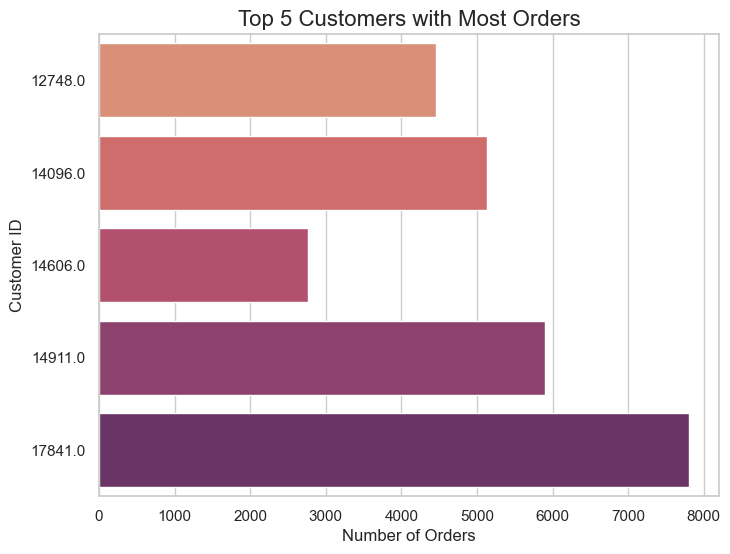

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotting Horizontal bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_customers.values, y=top_customers.index, palette='flare', orient='h')
plt.title('Top 5 Customers with Most Orders', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)
plt.show()


### 3. Product Analysis

In [119]:
# Q 1. Top 10 most frequently purchased products

top_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 most frequently purchased products:")
print(top_products)


Top 10 most frequently purchased products:
StockCode
84077     53119
22197     48689
85099B    44963
84879     35215
85123A    34185
21212     33386
23084     27045
22492     25880
22616     25305
21977     24129
Name: Quantity, dtype: int64


In [120]:
# 2. Average price of products

average_price = df['UnitPrice'].mean()
print(f"\nAverage price of products: ${average_price:.2f}")




Average price of products: $3.47


In [121]:
# 3. Revenue by Product (Total Revenue for each product)

df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
revenue_by_product = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
top_product = revenue_by_product.head(1)
print(f"\nProduct with Highest Revenue: {top_product}")


Product with Highest Revenue: Description
REGENCY CAKESTAND 3 TIER    132567.7
Name: TotalPrice, dtype: float64


# **RFM CALCULATIONS**

In [122]:
# Recency (R): How recently a customer made a purchase. Calculate the number of days since the customer's last purchase

# Convert InvoiceDate to datetime if it's not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculating the most recent date in the dataset
most_recent_date = df['InvoiceDate'].max()

# Calculating the difference between the order date and the most recent date
df['DaysSinceLastPurchase'] = \
(most_recent_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

recency_df = df.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()

recency_df.head()

,CustomerID,DaysSinceLastPurchase
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [123]:
# Recency (R): How recently a customer made a purchase. Calculate the number of days since the customer's last purchase

# First, convert InvoiceDate to datetime if it's not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculating the most recent date in the dataset
most_recent_date = df['InvoiceDate'].max()

# Calculating the difference between the order date and the most recent date
df['DaysSinceLastPurchase'] = \
(most_recent_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

recency_df = df.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()

recency_df.head()

,CustomerID,DaysSinceLastPurchase
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [124]:
# Recency (R): How recently a customer made a purchase. Calculate the number of days since the customer's last purchase

# First, convert InvoiceDate to datetime if it's not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculating the most recent date in the dataset
most_recent_date = df['InvoiceDate'].max()

# Calculating the difference between the order date and the most recent date
df['DaysSinceLastPurchase'] = \
(most_recent_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

recency_df = df.groupby('CustomerID')['DaysSinceLastPurchase'].min().reset_index()

recency_df.head()

,CustomerID,DaysSinceLastPurchase
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [125]:

#Frequency (F): How often a customer makes a purchase. Calculate the total number of orders for each customer

frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

frequency_df.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [126]:

#Monetary (M): The total monetary value of a customer's purchases. Calculate the sum of the total price for each customer

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

monetary_df.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [127]:
df['TransactionAmount'] = df['Quantity'] * df['UnitPrice']

In [128]:
monetary = df.groupby('CustomerID')['TransactionAmount'].sum().reset_index(name='MonetaryValue')

In [129]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TransactionAmount
df['TransactionAmount'] = df['Quantity'] * df['UnitPrice']

# Frequency: number of invoices per customer
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index(name='Frequency')

# Monetary value: total amount spent per customer
monetary = df.groupby('CustomerID')['TransactionAmount'].sum().reset_index(name='MonetaryValue')

# Recency: days since last purchase
max_date = df['InvoiceDate'].max()

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (max_date - recency['InvoiceDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# Merge into RFM table
RFM = frequency.merge(monetary, on='CustomerID').merge(recency, on='CustomerID')

RFM


,CustomerID,Frequency,MonetaryValue,Recency
0,12346.0,2,0.00,325
1,12347.0,7,4310.00,1
2,12348.0,4,1797.24,74
3,12349.0,1,1757.55,18
4,12350.0,1,334.40,309
...,...,...,...,...
4367,18280.0,1,180.60,277
4368,18281.0,1,80.82,180
4369,18282.0,3,176.60,7
4370,18283.0,16,2045.53,3


In [130]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create the Amount column
df['Amount'] = df['Quantity'] * df['UnitPrice']

# ---- FREQUENCY ----
frequency = df.groupby('CustomerID').size().reset_index(name='Frequency')

# ---- MONETARY ----
monetary = df.groupby('CustomerID')['Amount'].sum().reset_index(name='Monetary')

# ---- RECENCY ----
max_date = df['InvoiceDate'].max()

recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency['Recency'] = (max_date - recency['InvoiceDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

# ---- MERGE INTO RFM ----
RFM = frequency.merge(monetary, on='CustomerID').merge(recency, on='CustomerID')

RFM

,CustomerID,Frequency,Monetary,Recency
0,12346.0,2,0.00,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309
...,...,...,...,...
4367,18280.0,10,180.60,277
4368,18281.0,7,80.82,180
4369,18282.0,13,176.60,7
4370,18283.0,721,2045.53,3


# **RFM SEGMENTATION**

In [131]:
# Assigning R, F and M scores for each customer from their respective Data Frames

recency_df.sort_values(by= ['DaysSinceLastPurchase'], ascending = True, inplace = True)
recency_df['R_Score'] = pd.qcut(recency_df['DaysSinceLastPurchase'], q=[0, 0.25, 0.5, 0.75, 1], labels=False,\
                                duplicates = 'drop') + 1
recency_df['R_Score'].fillna(0.0, inplace = True)

recency_df

,CustomerID,DaysSinceLastPurchase,R_Score
3784,17491.0,0,1
3392,16933.0,0,1
3113,16558.0,0,1
524,13026.0,0,1
3691,17364.0,0,1
...,...,...,...
4212,18074.0,373,4
359,12791.0,373,4
4096,17908.0,373,4
3129,16583.0,373,4


In [132]:
frequency_df.sort_values(by= ['Frequency'], ascending = False, inplace = True)
frequency_df['F_Score'] = pd.qcut(frequency_df['Frequency'], q=[0, 0.25, 0.5, 0.75, 1], labels=False, duplicates='drop') + 1

frequency_df

,CustomerID,Frequency,F_Score
1895,14911.0,248,3
330,12748.0,224,3
4042,17841.0,169,3
1674,14606.0,128,3
568,13089.0,118,3
...,...,...,...
1141,13877.0,1,1
2997,16400.0,1,1
1142,13878.0,1,1
1149,13886.0,1,1


In [133]:
monetary_df.sort_values(by= ['Monetary'], ascending = False, inplace = True)
monetary_df['M_Score'] = pd.qcut(monetary_df['Monetary'], q=[0, 0.25, 0.5, 0.75, 1], labels=False, duplicates='drop') + 1

monetary_df

,CustomerID,Monetary,M_Score
1703,14646.0,279489.02,4
4233,18102.0,256438.49,4
3758,17450.0,187322.17,4
1895,14911.0,132458.73,4
55,12415.0,123725.45,4
...,...,...,...
125,12503.0,-1126.00,1
3870,17603.0,-1165.30,1
1384,14213.0,-1192.20,1
2236,15369.0,-1592.49,1


In [134]:
# Combining the R, F and M scores to create a single score
# The formula used to combine these scores : R * 100 + F * 10 + M

rfm_scores = pd.merge(recency_df[['CustomerID', 'R_Score']], frequency_df[['CustomerID', 'F_Score']], on='CustomerID')
rfm_scores = pd.merge(rfm_scores, monetary_df[['CustomerID', 'M_Score']], on='CustomerID')

rfm_scores['RFM_Score'] = rfm_scores['R_Score'] * 100 + rfm_scores['F_Score'] * 10 + rfm_scores['M_Score']
rfm_scores

,CustomerID,R_Score,F_Score,M_Score,RFM_Score
0,17491.0,1,3,4,134
1,16933.0,1,2,2,122
2,16558.0,1,3,4,134
3,13026.0,1,3,3,133
4,17364.0,1,3,4,134
...,...,...,...,...,...
4367,18074.0,4,1,2,412
4368,12791.0,4,1,1,411
4369,17908.0,4,1,1,411
4370,16583.0,4,1,1,411


# **CUSTOMER SEGMENTATION** 

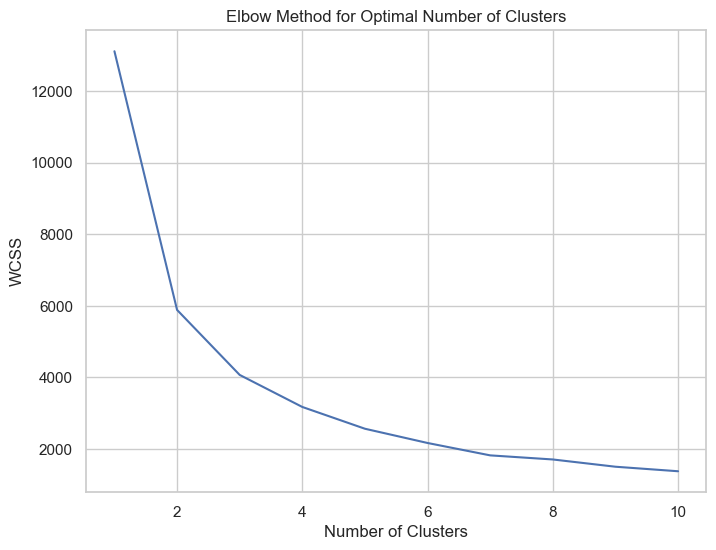

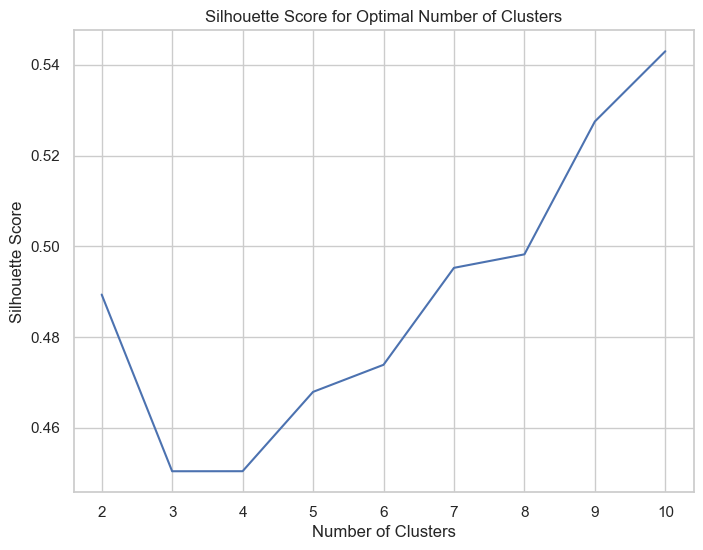

Cluster Summary:
           R_Score   F_Score   M_Score
Cluster                              
0        3.010902  1.225966  2.837463
1        1.595339  2.758475  3.635593
2        3.778166  1.039301  1.313537
3        1.552369  1.094763  1.764339


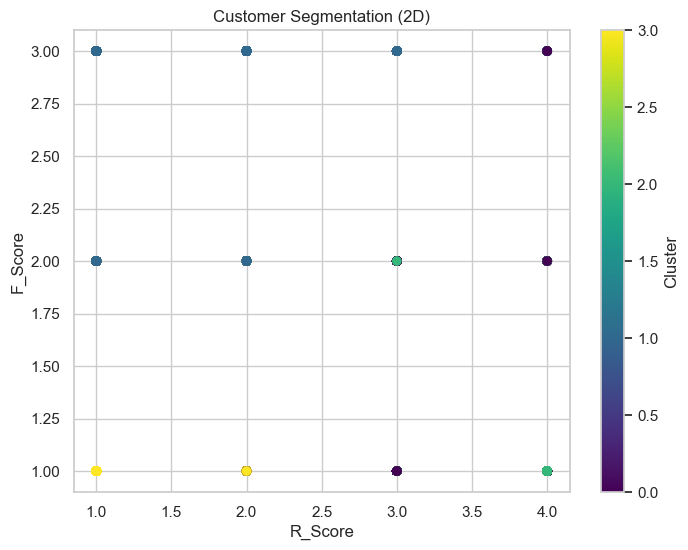

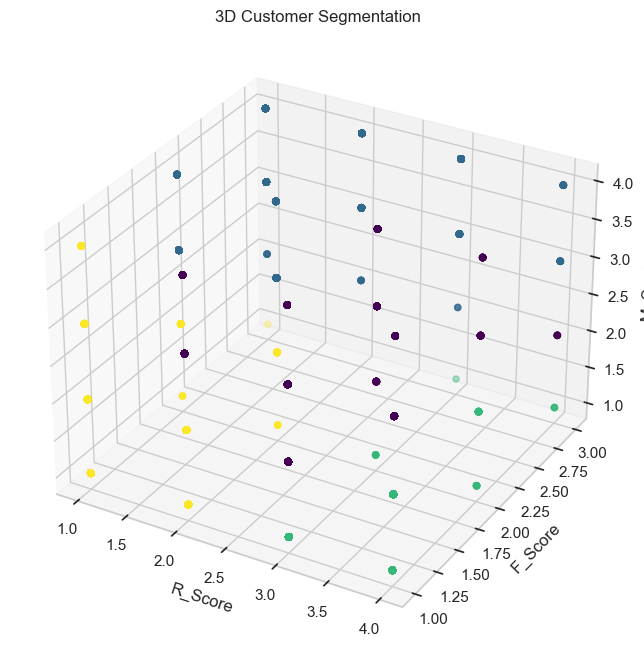

   CustomerID  R_Score  F_Score  M_Score  Cluster
0     17491.0        1        3        4        1
1     16933.0        1        2        2        3
2     16558.0        1        3        4        1
3     13026.0        1        3        3        1
4     17364.0        1        3        4        1


In [135]:
#CUSTOMER SEGMENTATION

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# Step 1: Convert RFM scores to numeric values
rfm_scores['R_Score'] = rfm_scores['R_Score'].astype(int)
rfm_scores['F_Score'] = rfm_scores['F_Score'].astype(int)
rfm_scores['M_Score'] = rfm_scores['M_Score'].astype(int)

# Step 2: Prepare the data for clustering (select RFM columns)
rfm_for_clustering =  rfm_scores[['R_Score', 'F_Score', 'M_Score']]

# Step 3: Standardize the data (scaling)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering)

# Step 4: Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):  # Trying 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Step 5: Silhouette Score to evaluate clustering quality
sil_scores = []
for i in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    sil_score = silhouette_score(rfm_scaled, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sil_scores)
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 6: Apply K-Means clustering with the optimal number of clusters (e.g., 4)
optimal_clusters = 4  # Replace with the optimal number based on your elbow/silhouette analysis
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
rfm_scores['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Step 7: Analyze the clusters (average RFM values per cluster)
cluster_summary = rfm_scores.groupby('Cluster')[['R_Score', 'F_Score', 'M_Score']].mean()
print("Cluster Summary:\n", cluster_summary)

# Step 8: Visualizing the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(rfm_scores['R_Score'], rfm_scores['F_Score'], c=rfm_scores['Cluster'], cmap='viridis')
plt.title('Customer Segmentation (2D)')
plt.xlabel('R_Score')
plt.ylabel('F_Score')
plt.colorbar(label='Cluster')
plt.show()

# Step 9:3D visualization (using R, F, and M scores)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_scores['R_Score'], rfm_scores['F_Score'], rfm_scores['M_Score'], c=rfm_scores['Cluster'], cmap='viridis')
ax.set_xlabel('R_Score')
ax.set_ylabel('F_Score')
ax.set_zlabel('M_Score')
plt.title('3D Customer Segmentation')
plt.show()

# Step 10: Display the final DataFrame with CustomerID and their assigned Cluster
print(rfm_scores[['CustomerID', 'R_Score', 'F_Score', 'M_Score', 'Cluster']].head())


In [136]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# For Cluster Size 3
kmeans_1 = KMeans(n_clusters=3, random_state=0)
labels_1 = kmeans_1.fit_predict(rfm_scaled)
silhouette_1 = silhouette_score(rfm_scaled, labels_1)

# For Cluster Size 4
kmeans_2 = KMeans(n_clusters=4, random_state=0)
labels_2 = kmeans_2.fit_predict(rfm_scaled)
silhouette_2 = silhouette_score(rfm_scaled, labels_2)

if(silhouette_1 > silhouette_2):
    print("Cluster Size 3 is optimal since ", round(silhouette_1, 2), " is greater than ", round(silhouette_2, 2))
else:
    print("Cluster Size 4 is optimal since ", round(silhouette_2, 2), " is greater than ", round(silhouette_1, 2))


Cluster Size 4 is optimal since  0.45  is greater than  0.42


In [137]:
optimal_k = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_scores['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm_scores

,CustomerID,R_Score,F_Score,M_Score,RFM_Score,Cluster
0,17491.0,1,3,4,134,0
1,16933.0,1,2,2,122,2
2,16558.0,1,3,4,134,0
3,13026.0,1,3,3,133,0
4,17364.0,1,3,4,134,0
...,...,...,...,...,...,...
4367,18074.0,4,1,2,412,1
4368,12791.0,4,1,1,411,1
4369,17908.0,4,1,1,411,1
4370,16583.0,4,1,1,411,1


In [138]:
rfm_scores['Cluster'].value_counts()

Cluster
1    1423
0    1283
3     880
2     786
Name: count, dtype: int64

# **SEGMENT PROFILLING**

In [139]:
#SEGMENT PROFILING

# Step 1: Calculate the average RFM scores for each cluster (segment)
cluster_profile = rfm_scores.groupby('Cluster')[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].mean()

# Step 2: Calculate the number of customers in each cluster
segment_counts = rfm_scores['Cluster'].value_counts()

# Step 3: Analyze and describe each customer segment
profile_description = {}
for cluster_id in cluster_profile.index:
    r_score = cluster_profile.loc[cluster_id, 'R_Score']
    f_score = cluster_profile.loc[cluster_id, 'F_Score']
    m_score = cluster_profile.loc[cluster_id, 'M_Score']
    
    if r_score > 3 and f_score > 3 and m_score > 3:
        segment = "High Value Customers"
    elif r_score <= 2 and f_score <= 2 and m_score <= 2:
        segment = "Low Value Customers"
    elif r_score <= 2 and f_score > 3 and m_score > 3:
        segment = "Frequent High Spenders"
    elif r_score > 3 and f_score <= 2 and m_score <= 2:
        segment = "Recent Low Spenders"
    else:
        segment = "Other Segment"

    profile_description[cluster_id] = {
        'R_Score': r_score,
        'F_Score': f_score,
        'M_Score': m_score,
        'Customer_Count': segment_counts[cluster_id],
        'Segment_Description': segment
    }

# Step 4: Display the segment profiles
segment_profiles_df = pd.DataFrame(profile_description).T
print(segment_profiles_df)




    R_Score   F_Score   M_Score Customer_Count  Segment_Description
0  1.533125  2.826968  3.701481           1283        Other Segment
1  3.626142  1.031623  1.447646           1423  Recent Low Spenders
2  1.563613  1.096692   1.71883            786  Low Value Customers
3  2.854545     1.425  3.147727            880        Other Segment


# **MARKETING RECOMMENDATIONS** 

In [140]:
cluster_profile = rfm_scores.groupby('Cluster')[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].mean()
marketing_recommendations = {
    'High Value Customers': {
        'Segment Description': 'High Recency, High Frequency, High Monetary',
        'RFM Characteristics': 'High R-score, High F-score, High M-score',
        'Recommendations': [
            'Exclusive VIP Events: Organize private online or offline events for high-value customers.',
            'Advanced Personalization: Leverage AI-driven product recommendations based on customer history.',
            'Premium Customer Service: Provide a dedicated customer service team or account manager.',
            'Early-Bird Offers: Give them access to products or promotions before they are available to others.'
        ]
    },
    'Low Value Customers': {
        'Segment Description': 'Low Recency, Low Frequency, Low Monetary',
        'RFM Characteristics': 'Low R-score, Low F-score, Low M-score',
        'Recommendations': [
            'Welcome Offers: Provide substantial discounts or free shipping on their next purchase.',
            'Product Re-engagement: Showcase new arrivals or bestsellers with personalized recommendations.',
            'Behavioral Triggers: Send reminders or notifications about items they’ve shown interest in.',
            'Surveys and Feedback: Engage them by asking for feedback and offering a discount for completing surveys.'
        ]
    },
    'Frequent High Spenders': {
        'Segment Description': 'Low Recency, High Frequency, High Monetary',
        'RFM Characteristics': 'Low R-score, High F-score, High M-score',
        'Recommendations': [
            'Loyalty Bonuses: Offer reward points for every purchase, which can be redeemed for discounts.',
            'Bundle Deals: Provide bundle offers on frequently purchased items to encourage more spending.',
            'Exclusive Offers: Give them access to member-only sales or promotions.',
            'Seasonal Specials: Offer special deals during peak shopping seasons or events.'
        ]
    },
    'Recent Low Spenders': {
        'Segment Description': 'High Recency, Low Frequency, Low Monetary',
        'RFM Characteristics': 'High R-score, Low F-score, Low M-score',
        'Recommendations': [
            'Nurture Engagement: Send product tutorials or guides to keep them engaged with the brand.',
            'Customer Appreciation Offers: Show appreciation with personalized thank you notes and discounts.',
            'Follow-up Campaigns: Send follow-up emails with targeted offers or product suggestions.',
            'Retargeting Ads: Use retargeting ads to remind them of their recent interest and offer discounts.'
        ]
    },
    'Other Segments': {
        'Segment Description': 'Mixed RFM characteristics (varying R, F, M)',
        'RFM Characteristics': 'Varied R, F, and M scores',
        'Recommendations': [
            'Dynamic Pricing: Introduce dynamic pricing based on customer behavior and purchase history.',
            'Content Marketing: Share blog posts, videos, or infographics related to products and services.',
            'Geo-targeting: Target users with offers based on their geographic location and shopping trends.',
            'Cross-platform Engagement: Create cross-platform campaigns to engage customers through email, social media, and mobile apps.'
        ]
    }
}
# Display the cluster profile and tailored marketing strategies
print("Cluster Profiling (RFM Averages):")
print(cluster_profile)

print("\nTailored Marketing Strategies for Each Segment:")
for segment, details in marketing_recommendations.items():
    print(f"\nSegment: {segment}")
    print(f"Description: {details['Segment Description']}")
    print(f"RFM Characteristics: {details['RFM Characteristics']}")
    print("Recommendations:")
    for rec in details['Recommendations']:
        print(f"- {rec}")


Cluster Profiling (RFM Averages):
          R_Score   F_Score   M_Score   RFM_Score
Cluster                                          
0        1.533125  2.826968  3.701481  185.283710
1        3.626142  1.031623  1.447646  374.378074
2        1.563613  1.096692  1.718830  169.047074
3        2.854545  1.425000  3.147727  302.852273

Tailored Marketing Strategies for Each Segment:

Segment: High Value Customers
Description: High Recency, High Frequency, High Monetary
RFM Characteristics: High R-score, High F-score, High M-score
Recommendations:
- Exclusive VIP Events: Organize private online or offline events for high-value customers.
- Advanced Personalization: Leverage AI-driven product recommendations based on customer history.
- Premium Customer Service: Provide a dedicated customer service team or account manager.
- Early-Bird Offers: Give them access to products or promotions before they are available to others.

Segment: Low Value Customers
Description: Low Recency, Low Frequency

# **VISUALIZATION**

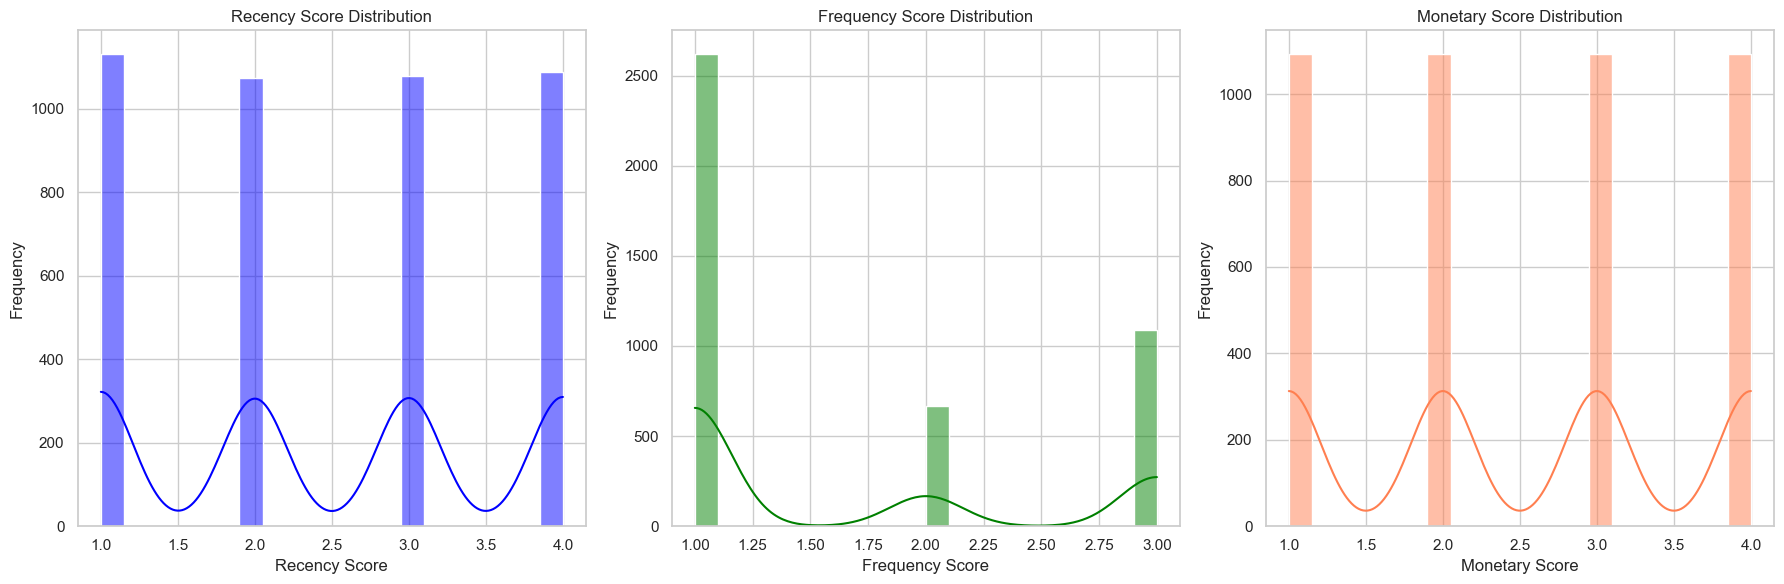

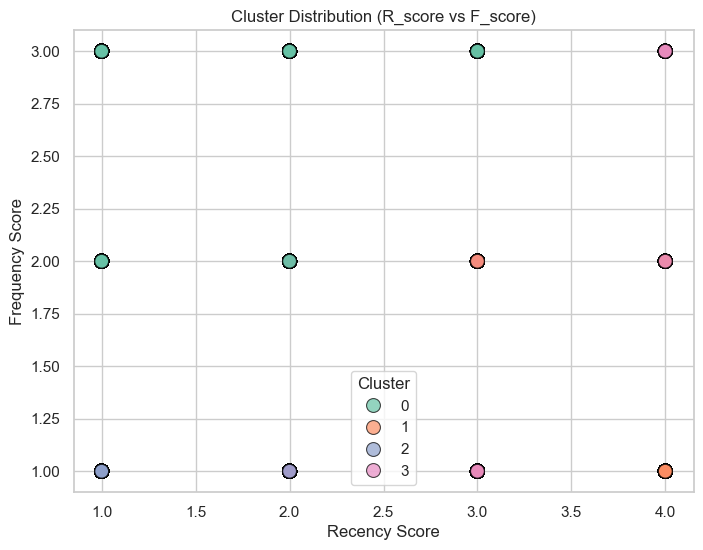

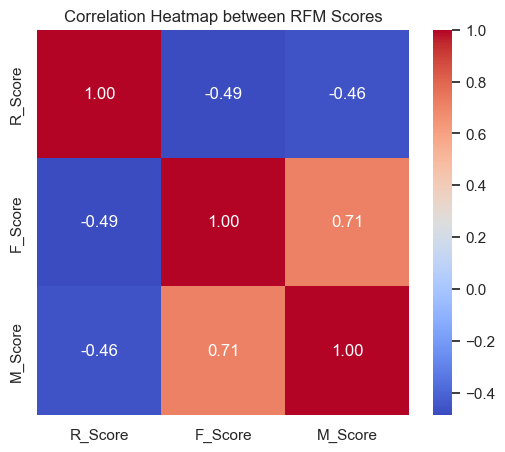

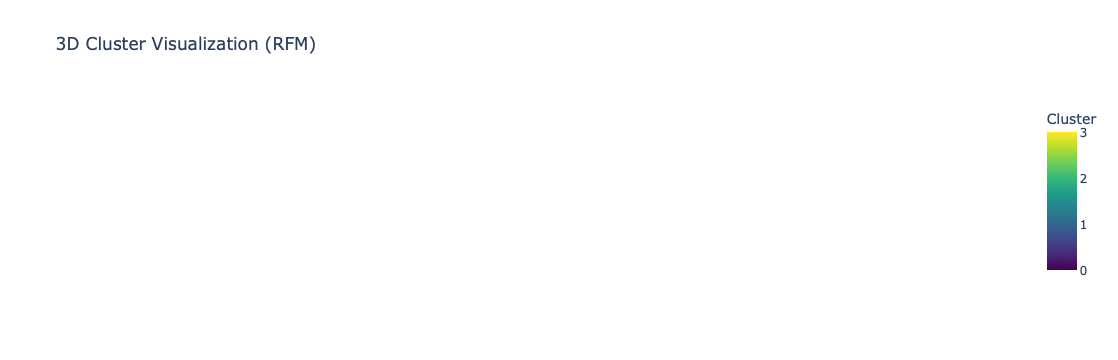

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import plotly.express as px



# Set up the plot style
sns.set(style="whitegrid")

# Plotting histograms for RFM distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(rfm_scores['R_Score'], bins=20, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Recency Score Distribution')
axes[0].set_xlabel('Recency Score')
axes[0].set_ylabel('Frequency')

sns.histplot(rfm_scores['F_Score'], bins=20, kde=True, color='green', ax=axes[1])
axes[1].set_title('Frequency Score Distribution')
axes[1].set_xlabel('Frequency Score')
axes[1].set_ylabel('Frequency')

sns.histplot(rfm_scores['M_Score'], bins=20, kde=True, color='coral', ax=axes[2])
axes[2].set_title('Monetary Score Distribution')
axes[2].set_xlabel('Monetary Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Scatter plot of RFM scores with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_scores, x='R_Score', y='F_Score', hue='Cluster', palette='Set2', s=100, alpha=0.7, edgecolor='black')
plt.title('Cluster Distribution (R_score vs F_score)')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.legend(title='Cluster')
plt.show()



# Calculate correlation matrix for RFM scores
correlation_matrix = rfm_scores[['R_Score', 'F_Score', 'M_Score']].corr()

# Create a heatmap to visualize the correlation between RFM scores
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between RFM Scores')
plt.show()


# 3D Scatter Plot for RFM Clusters
fig = px.scatter_3d(rfm_scores, x='R_Score', y='F_Score', z='M_Score', color='Cluster',
                    labels={'R_Score': 'Recency Score', 'F_Score': 'Frequency Score', 'M_Score': 'Monetary Score'},
                    title="3D Cluster Visualization (RFM)",
                    color_continuous_scale='Viridis')
fig.show()


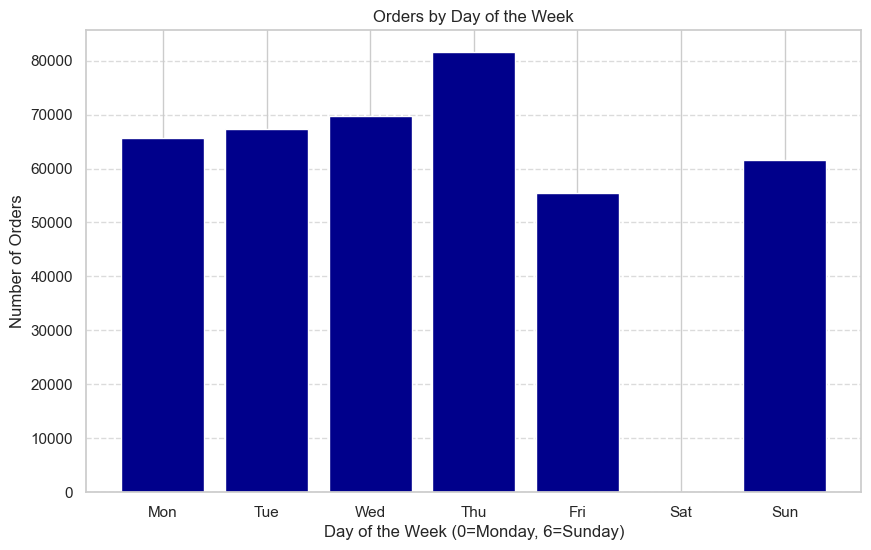

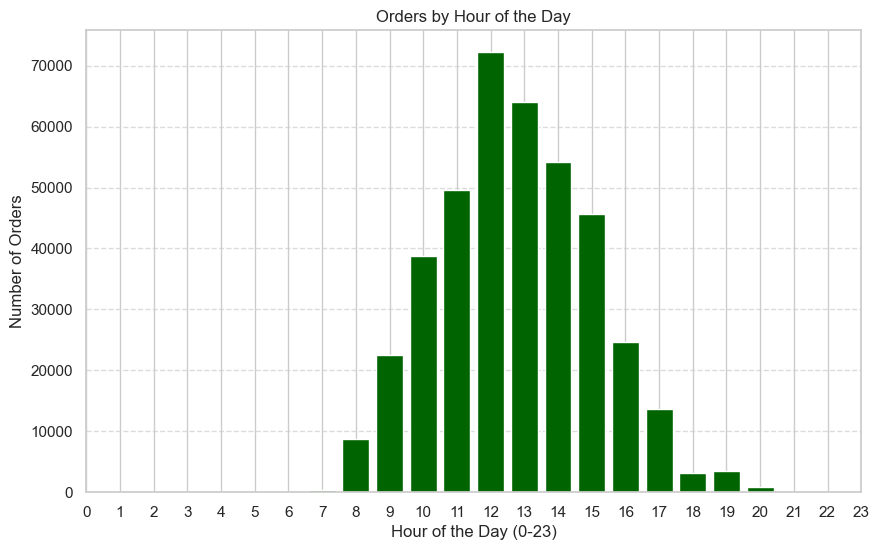

In [142]:
#Time Analysis

import matplotlib.pyplot as plt

# 1. Day of the Week or Time of Day Analysis
# Extract day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
# Extract hour of the day (0-23)
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Orders by day of the week
orders_by_day = df['DayOfWeek'].value_counts().sort_index()

# Orders by hour of the day
orders_by_hour = df['HourOfDay'].value_counts().sort_index()

# Plotting Orders by Day of the Week
plt.figure(figsize=(10, 6))
plt.bar(orders_by_day.index, orders_by_day.values, color='darkblue')
plt.title('Orders by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Orders')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting Orders by Hour of the Day
plt.figure(figsize=(10, 6))
plt.bar(orders_by_hour.index, orders_by_hour.values, color='darkgreen')
plt.title('Orders by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Orders')
plt.xticks(range(0, 24, 1))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()



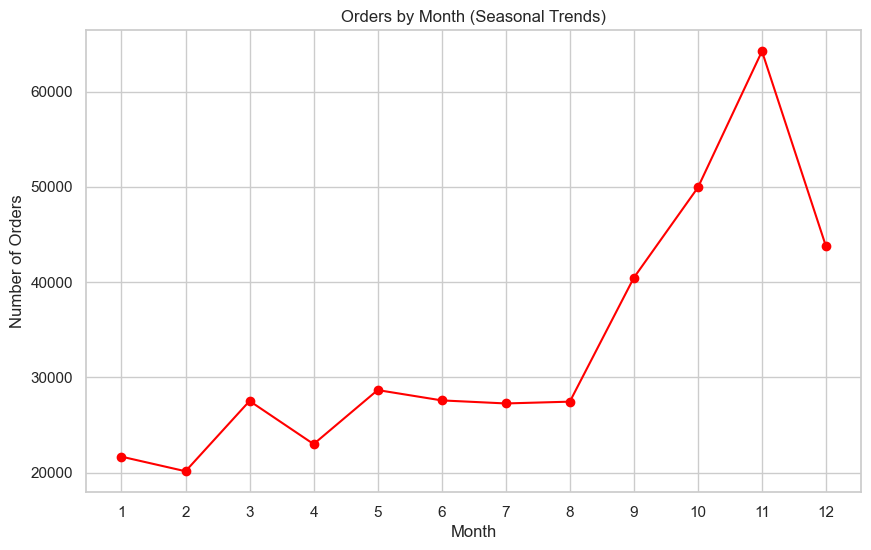

In [143]:
# 2. Seasonal Trends Analysis (Month-based analysis)
df['Month'] = df['InvoiceDate'].dt.month
orders_by_month = df['Month'].value_counts().sort_index()

# Plotting Seasonal Trends
plt.figure(figsize=(10, 6))
plt.plot(orders_by_month.index, orders_by_month.values, marker='o', color='red')
plt.title('Orders by Month (Seasonal Trends)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

### 5. Geographical Analysis

Top 5 Countries with the Highest Number of Orders:
Country
United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Name: count, dtype: int64


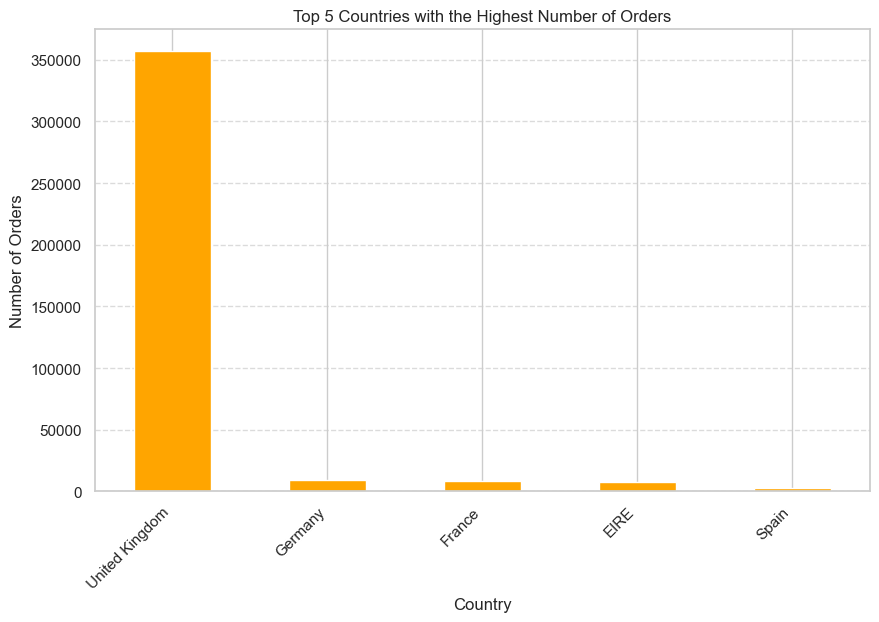

In [144]:
#Geographical Analysis

from sklearn.preprocessing import LabelEncoder

# 1. Top 5 Countries with the Highest Number of Orders
orders_by_country = df['Country'].value_counts().head(5)

# Print the top 5 countries with the highest number of orders
print("Top 5 Countries with the Highest Number of Orders:")
print(orders_by_country)

# Plotting the top 5 countries with the highest number of orders
plt.figure(figsize=(10, 6))
orders_by_country.plot(kind='bar', color='orange')
plt.title('Top 5 Countries with the Highest Number of Orders')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()




Average Order Value (AOV) by Country:
Country
Australia               1985.648841
Austria                  534.437895
Bahrain                  274.200000
Belgium                  343.789580
Brazil                  1143.600000
Canada                   611.063333
Channel Islands          608.375455
Cyprus                   642.938000
Czech Republic           141.544000
Denmark                  893.720952
EIRE                     783.704639
European Community       258.350000
Finland                  465.140417
France                   429.314520
Germany                  367.345721
Greece                   785.086667
Iceland                  615.714286
Israel                  1164.733333
Italy                    307.100182
Japan                   1262.165000
Lebanon                 1693.880000
Lithuania                415.265000
Malta                    250.547000
Netherlands             2818.431089
Norway                   879.086500
Poland                   300.547500
Portugal         

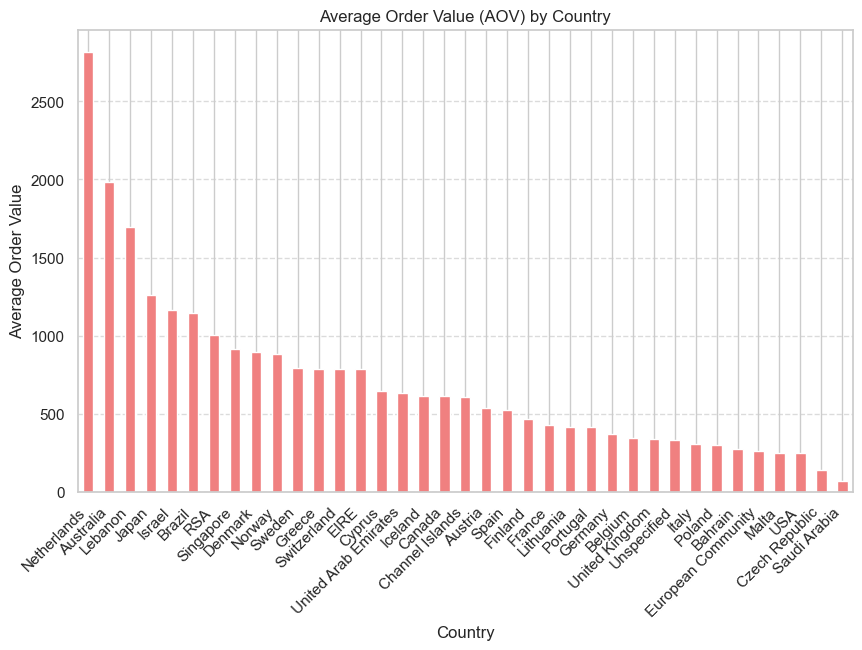


Correlation between Country and Average Order Value (AOV): -0.07873690571956296


In [145]:
# 2. Correlation Between Customer's Country and Average Order Value (AOV)

# Calculate total order value per country (assuming 'TotalPrice' is already computed as price * quantity)
aov_by_country = df.groupby('Country')['TotalPrice'].sum() / df.groupby('Country')['InvoiceNo'].nunique()

# Display the average order value for each country
print("\nAverage Order Value (AOV) by Country:")
print(aov_by_country)

#plot AOV by country
plt.figure(figsize=(10, 6))
aov_by_country.sort_values(ascending=False).plot(kind='bar', color='lightcoral')
plt.title('Average Order Value (AOV) by Country')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Correlation Check between Country and AOV using LabelEncoder
# Encode countries as numerical values using LabelEncoder
label_encoder = LabelEncoder()
df['CountryEncoded'] = label_encoder.fit_transform(df['Country'])

# Now, calculate the AOV by country (as a separate series)
aov_by_country = df.groupby('Country')['TotalPrice'].sum() / df.groupby('Country')['InvoiceNo'].nunique()

# Merge AOV with the encoded countries
aov_with_country = pd.DataFrame({
    'CountryEncoded': df.groupby('Country')['CountryEncoded'].first(),  # Take the first encoded value per country
    'AOV': aov_by_country
})

# Now compute the correlation between encoded country and AOV
correlation = aov_with_country['AOV'].corr(aov_with_country['CountryEncoded'])

print(f"\nCorrelation between Country and Average Order Value (AOV): {correlation}")


### 8. Returns and Refunds


Return rate by product category:
                 return_rate
ProductCategory             
Books                  100.0
Gifts                  100.0
Other                  100.0


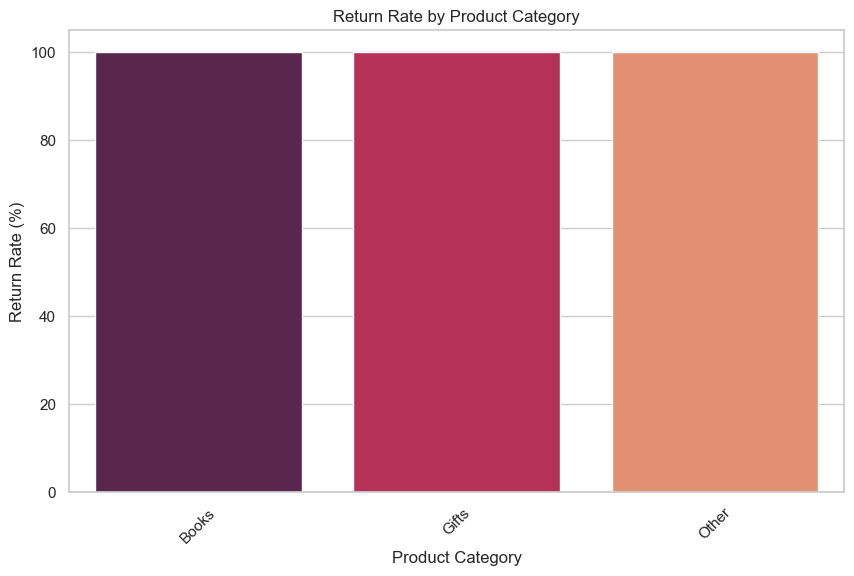


Percentage of orders with returns or refunds: 16.47%


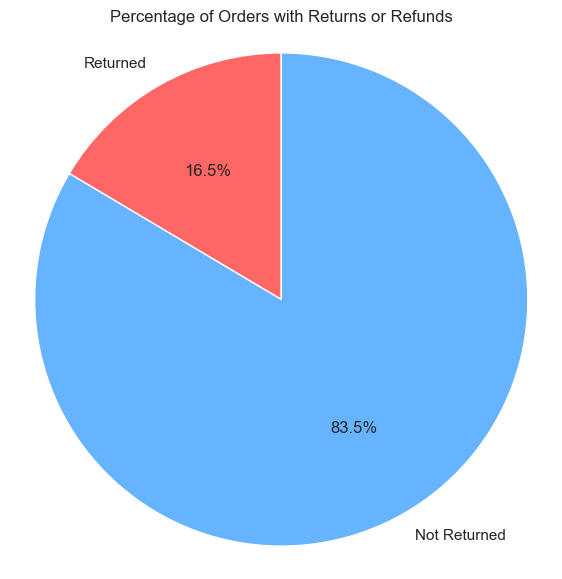

In [146]:
#Returns and Refunds

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Define the categorize_product function to handle NaN or non-string values
def categorize_product(description):
    # Ensure the description is a string and handle NaN values
    description = str(description).lower()
    
    if 'gift' in description:
        return 'Gifts'
    elif 'shirt' in description:
        return 'Apparel'
    elif 'book' in description:
        return 'Books'
    elif 'electronic' in description:
        return 'Electronics'
    else:
        return 'Other'

# Step 2: Apply the categorization function to the 'Description' column
df['ProductCategory'] = df['Description'].apply(categorize_product)

# Step 3: Filter the DataFrame to only include rows with returns (negative quantities)
df_returns = df[df['Quantity'] < 0]

# Step 4: Calculate the total returns and total orders per product category
category_returns = df_returns.groupby('ProductCategory').agg(
    total_returns=('InvoiceNo', 'nunique'),
    total_orders=('InvoiceNo', 'nunique')
)

# Step 5: Calculate the return rate for each category (percentage of returns)
category_returns['return_rate'] = (category_returns['total_returns'] / category_returns['total_orders']) * 100

# Step 6: Display the return rate by product category
print("\nReturn rate by product category:")
print(category_returns[['return_rate']])

# Step 7: Visualization of return rate by category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_returns.index, y=category_returns['return_rate'], palette='rocket')
plt.title('Return Rate by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Return Rate (%)')
plt.xticks(rotation=45)
plt.show()

# Step 8: Calculate the percentage of orders that have experienced returns or refunds
total_orders = df['InvoiceNo'].nunique()
total_returns = df_returns['InvoiceNo'].nunique()

return_percentage = (total_returns / total_orders) * 100

print(f"\nPercentage of orders with returns or refunds: {return_percentage:.2f}%")

#visualizing the overall return percentage as a pie chart
labels = ['Returned', 'Not Returned']
sizes = [total_returns, total_orders - total_returns]
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff6666', '#66b3ff'])
plt.title('Percentage of Orders with Returns or Refunds')
plt.axis('equal')
plt.show()


### 9. Profitability Analysis

Total Profit Generated by the Company: $3311407.77

Top 5 Products with the Highest Profit Margins:
                                 total_profit  profit_margin
Description                                                 
SET OF 3 BABUSHKA STACKING TINS        25.440           40.0
FLOWER FAIRY INCENSE BOUQUET           12.940           40.0
GLASS CHALICE GREEN  LARGE            117.984           40.0
MOP PENDANT SHELL NECKLACE             17.820           40.0
CAST IRON HOOK GARDEN FORK            548.572           40.0


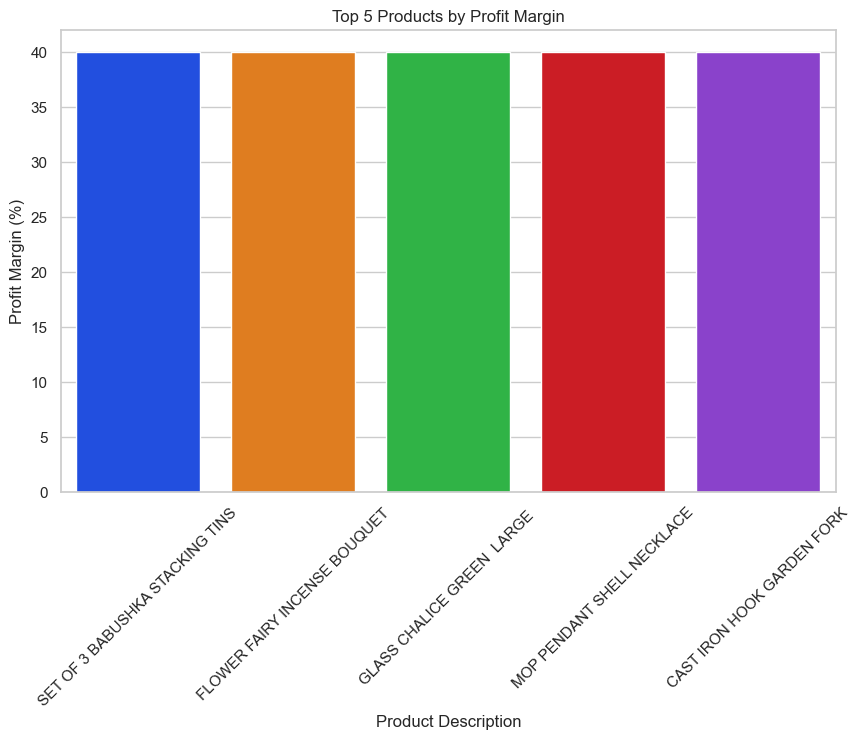

In [147]:


#Profitability Analysis

import pandas as pd


# Step 1: Calculate the Profit for each transaction
# If we assume that the cost is some percentage of the 'UnitPrice', for example, 60% of the UnitPrice is the cost, 
# we can compute profit by subtracting the cost from the revenue (TotalPrice = UnitPrice * Quantity).
profit_margin_percentage = 0.4  # Example: 40% profit margin, so 60% of UnitPrice is cost
df['Profit'] = df['TotalPrice'] * profit_margin_percentage

# Step 2: Calculate total profit over all transactions
total_profit = df['Profit'].sum()
print(f"Total Profit Generated by the Company: ${total_profit:.2f}")

# Step 3: Calculate the profit margin for each product
# Group by 'Description' (or 'StockCode' if you have it) to calculate the total profit for each product
product_profit = df.groupby('Description').agg(
    total_profit=('Profit', 'sum'),
    total_revenue=('TotalPrice', 'sum')
)

# Calculate profit margin for each product
product_profit['profit_margin'] = (product_profit['total_profit'] / product_profit['total_revenue']) * 100

# Step 4: Get top 5 products by profit margin
top_5_products = product_profit.sort_values(by='profit_margin', ascending=False).head(5)

print("\nTop 5 Products with the Highest Profit Margins:")
print(top_5_products[['total_profit', 'profit_margin']])

# Step 5: Visualization of the top 5 products by profit margin
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_products.index, y=top_5_products['profit_margin'], palette='bright')
plt.title('Top 5 Products by Profit Margin')
plt.xlabel('Product Description')
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=45)
plt.show()

# **CONCLUSION**

#### In conclusion, the collection of Python scripts provides an extensive analysis of customer data. Starting with data importation and preparation, the scripts progress into exploratory data analysis, offering valuable insights into payment methods, order volumes, and regional order patterns. Time-related analysis highlights key trends like average processing times and seasonal fluctuations. RFM analysis, customer segmentation, and visualizations, including scatter plots and 3D charts, provide a detailed look into customer behavior. Additionally, the analysis of customer activity duration and product profitability, along with sentiment analysis, adds further depth to the findings. Together, these insights give businesses actionable information for making informed decisions in marketing, customer engagement, and product management. The visualizations help clarify complex trends and support effective communication of the results.